In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import project_env as pe
import sklearn as sklearn
import math
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from itertools import product
import error_analysis as ea
from sklearn.metrics import precision_recall_curve
from scipy.stats.stats import pearsonr
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble.partial_dependence import plot_partial_dependence
%matplotlib inline

In [2]:
train = pd.read_csv('data_processing/output/train.csv')
val = pd.read_csv('data_processing/output/val.csv')
test = pd.read_csv('data_processing/output/test.csv')

# Target Variable

In [3]:
#target variable of rearrest in 5 years
X_train, y_train = pe.create_target(train, years = 5)
X_val, y_val = pe.create_target(val, years = 5)

X_test, y_test = pe.create_target(test, years = 5)

In [4]:
unique, counts = np.unique(y_train, return_counts = True)
percent = counts[1]/counts.sum()
print('Training: %s percent were rearrested.' %(percent*100))

unique, counts = np.unique(y_val, return_counts = True)
percent = counts[1]/counts.sum()
print('Test: %s percent were rearrested.' %(percent*100))


Training: 51.9046644379 percent were rearrested.
Test: 51.8282699654 percent were rearrested.


In [5]:
#remove non-feature columns
X_train=X_train.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)
X_val=X_val.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables
X_train=X_train.drop(['ARREST_DATE', 'ARREST_DATE_y'], axis=1)
X_val=X_val.drop(['ARREST_DATE','ARREST_DATE_y'], axis=1)

In [6]:
#remove non-feature columns
X_test=X_test.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables
X_test=X_test.drop(['ARREST_DATE', 'ARREST_DATE_y'], axis=1)

# Gradient Boosted Trees

### Parameter Optimization

In [11]:
n_estimators = [100, 300, 500]
learning_rates = [0.05, 0.1, 0.5]
max_depths = [3,5,10]
min_samples_splits = [2,4,8]

In [12]:
model_specs = pd.DataFrame(list(product(n_estimators, learning_rates, max_depths, min_samples_splits)),\
             columns=['n_estimator', 'learning_rate', 'max_depth', 'min_samples_split'])

model_specs['ModelID'] = range(1, len(model_specs)+1)

model_specs['ModelID'] = 'Model' + model_specs['ModelID'].astype(str)

model_specs.head()

,n_estimator,learning_rate,max_depth,min_samples_split,ModelID
0,100,0.05,3,2,Model1
1,100,0.05,3,4,Model2
2,100,0.05,3,8,Model3
3,100,0.05,5,2,Model4
4,100,0.05,5,4,Model5


In [13]:
models = {}

for i in range(len(model_specs)):
    models[model_specs.iloc[i,:]['ModelID']] = \
    GradientBoostingClassifier(n_estimators = int(model_specs.iloc[i,:]['n_estimator']),\
                               learning_rate = float(model_specs.iloc[i,:]['learning_rate']),\
                               max_depth = int(model_specs.iloc[i,:]['max_depth']),\
                               min_samples_split = int(model_specs.iloc[i,:]['min_samples_split'])
                              )

In [16]:
models_fit = {k: v.fit(X_train,y_train) for k, v in models.items()}

In [18]:
models_predict_val = {k: v.predict(X_val) for k, v in models_fit.items()}

In [19]:
models_predict_prob = {k: v.predict_proba(X_val) for k, v in models_fit.items()}

In [20]:
model_specs.index = model_specs['ModelID']

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Val Accuracy'] = \
    sklearn.metrics.accuracy_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Precision'] = \
    sklearn.metrics.precision_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Recall'] = \
    sklearn.metrics.recall_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'F-Score'] = \
    sklearn.metrics.f1_score(y_val, models_predict_val[model_num])

In [21]:
#best model
model_specs.loc[model_specs['F-Score'].idxmax(axis=1),]

n_estimator               500
learning_rate            0.05
max_depth                   5
min_samples_split           4
ModelID               Model59
Val Accuracy         0.758232
Precision            0.760899
Recall               0.777992
F-Score              0.769351
Name: Model59, dtype: object

In [ ]:
#Different from the "best model" in the first run - the n_estimator and learning_rate have changed

In [25]:
best_model = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.05, max_depth = 5, min_samples_split = 4)

best_model.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=4, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [22]:
model_specs.to_csv('results/gbt_optimization_results.csv')

#### Best Model's Predictions and Feature Importance

In [26]:
best_model_predicted_prob = best_model.predict_proba(X_val)
best_model_predictions = best_model.predict(X_val)

In [27]:
feature_imp = pd.DataFrame(list(zip(X_train.columns, best_model.feature_importances_)))
feature_imp.columns = ['Column Name', 'Importance']
print (feature_imp.sort(columns = 'Importance', ascending = False)[0:5].to_latex())

\begin{tabular}{llr}
\toprule
{} &       Column Name &  Importance \\
\midrule
9  &               AGE &    0.213090 \\
0  &    BAR\_ADMIT\_DAYS &    0.167999 \\
12 &  ARREST\_TO\_SCREEN &    0.124242 \\
8  &    SCREENING\_DAYS &    0.073653 \\
1  &     CRIMINAL\_FLAG &    0.058183 \\
\bottomrule
\end{tabular}



/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


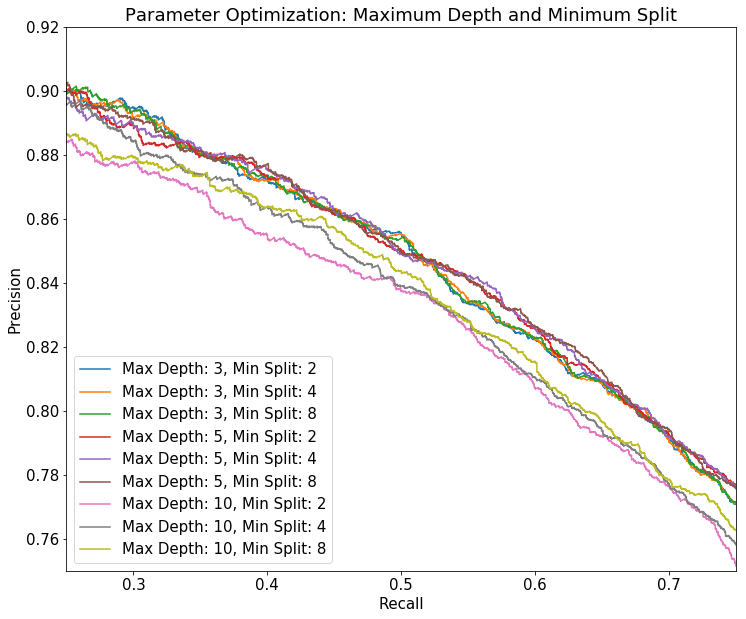

In [30]:
for model_num in list(model_specs[(model_specs['learning_rate']==0.05) & (model_specs['n_estimator']==500)]['ModelID']):
    curve = precision_recall_curve(y_val, models_predict_prob[model_num][:,1])
    precision, recall, thresholds = curve
    l = 'Max Depth: ' + str(model_specs.loc[model_num, 'max_depth']) + ', Min Split: ' + str(model_specs.loc[model_num, 'min_samples_split'])
    line = pylab.plot(recall, precision, label = l)
    pylab.legend(loc='lower left', fontsize = 15)
    pylab.xlim(.25,.75)
    pylab.ylim(.75, .92)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    pylab.xlabel('Recall', fontsize = 15)
    pylab.ylabel('Precision', fontsize = 15)
    pylab.title('Parameter Optimization: Maximum Depth and Minimum Split', fontdict = {'fontsize': 18})
    
plt.gcf().set_size_inches(12,10) 
plt.savefig('precision_recall_param_opt_depth_split.png')
plt.show()

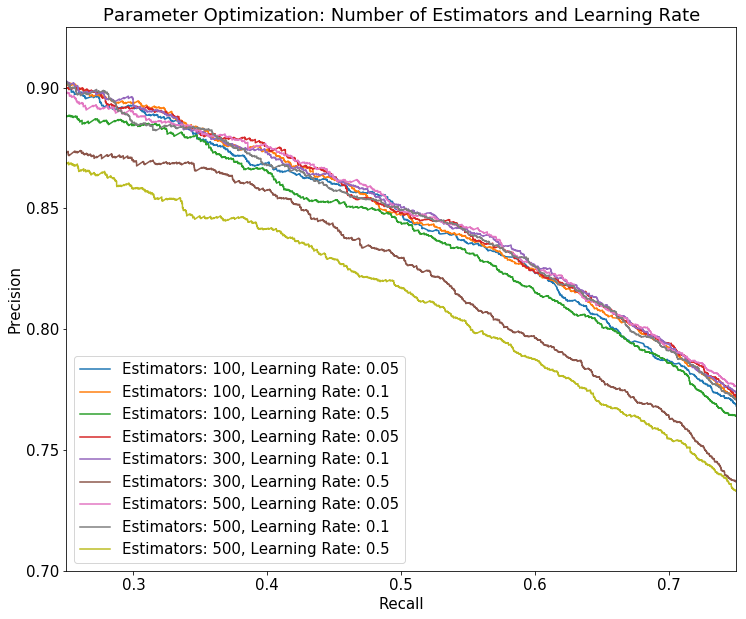

In [31]:
for model_num in list(model_specs[(model_specs['max_depth']==5) & (model_specs['min_samples_split']==4)]['ModelID']):
    curve = precision_recall_curve(y_val, models_predict_prob[model_num][:,1])
    precision, recall, thresholds = curve
    l = 'Estimators: ' + str(model_specs.loc[model_num, 'n_estimator']) +\
    ', Learning Rate: ' + str(model_specs.loc[model_num, 'learning_rate'])
    line = pylab.plot(recall, precision, label = l)
    pylab.legend(loc='lower left', fontsize = 15)
    pylab.xlim(.25,.75)
    pylab.ylim(.70, .925)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    pylab.xlabel('Recall', fontsize = 15)
    pylab.ylabel('Precision', fontsize = 15)
    pylab.title('Parameter Optimization: Number of Estimators and Learning Rate', fontdict = {'fontsize': 18})
    
plt.gcf().set_size_inches(12,10) 
plt.savefig('precision_recall_param_opt_est_lr.png')
plt.show()

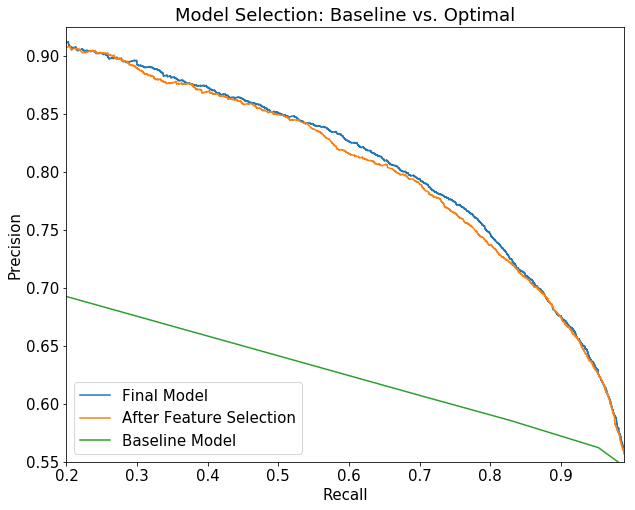

In [32]:
curve = precision_recall_curve(y_val, models_predict_prob['Model41'][:,1])
precision, recall, thresholds = curve
line = pylab.plot(recall, precision, label = 'Final Model')

curve = precision_recall_curve(y_val, models_predict_prob['Model10'][:,1])
precision, recall, thresholds = curve
line = pylab.plot(recall, precision, label = 'After Feature Selection')

baseline_precision = np.load('precision_baseline.npy')
baseline_recall = np.load('recall_baseline.npy')

line = pylab.plot(baseline_recall, baseline_precision, label = 'Baseline Model')

pylab.legend(loc='lower left', fontsize = 15)
pylab.xlim(.20,.99)
pylab.ylim(.55, .925)
pylab.xlabel('Recall', fontsize = 15)
pylab.ylabel('Precision', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
pylab.title('Model Selection: Baseline vs. Optimal', fontdict = {'fontsize': 18})
    
plt.gcf().set_size_inches(10,8) 
plt.savefig('precision_recall_baseline_v_optimal.png')
plt.show()

### Confusion Matrix and Risk CSV

In [33]:
gbt_cm = sklearn.metrics.confusion_matrix(y_val,models_predict_val['Model41'])
gbt_cm    #add cm.to_latex?
print (pd.DataFrame(gbt_cm).to_latex())

\begin{tabular}{lrr}
\toprule
{} &     0 &     1 \\
\midrule
0 &  3917 &  1379 \\
1 &  1277 &  4421 \\
\bottomrule
\end{tabular}



In [34]:
#target variable of rearrest in 5 years
og_X_train, og_y_train = pe.create_target(train, years = 5)
og_X_val, og_y_val = pe.create_target(val, years = 5)
og_X_test, og_y_test = pe.create_target(test, years = 5)

In [79]:
val_predict_proba = models_fit['Model59'].predict_proba(X_val)

test_predict_proba = models_fit['Model59'].predict_proba(X_test)

train_predict_proba = models_fit['Model59'].predict_proba(X_train)

In [ ]:
val_risk = og_X_val[['BOFI_NBR', 'UNIQUE_ID']]
val_risk['Risk'] = val_predict_proba[:,1].copy()

In [78]:
test_risk = og_X_test[['BOFI_NBR', 'UNIQUE_ID']]
test_risk['Risk'] = test_predict_proba[:,1].copy()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [37]:
train_risk = og_X_train[['BOFI_NBR', 'UNIQUE_ID']]
train_risk['Risk'] = train_predict_proba[:,1].copy()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

In [83]:
test_risk.to_csv('results/test_risk.csv')
train_risk.to_csv('results/train_risk.csv')
val_risk.to_csv('results/val_risk.csv')

### Error Analysis (Perform on the best model)

In [ ]:
#Need to run this on the original validation dataset before one hot encoding - with the new dummy variables and imputation preprocessing

In [39]:
#preds_to_analyze = models_predict_val['Model41']

preds_to_analyze = best_model_predictions

np.save('pred_val_5yr_gbt_optimal.npy', preds_to_analyze)

In [40]:
probs_to_analyze = best_model_predicted_prob

In [42]:
val['AGE'] = val['AGE']/365

In [56]:
val.columns

Index(['UNIQUE_ID', 'NEXT_ARREST_TIME', 'ARREST_DATE', 'ARREST_DATE_y',
       'BOFI_NBR', 'SCREENING_DISP_CODE', 'BAR_ADMIT_DAYS', 'CRIMINAL_FLAG',
       'FINAL_DETENTION_FLAG', 'HABITUAL_OFFENDER_FLAG',
       'INITIAL_DETENTION_FLAG', 'JUVENILE_FLAG', 'TOT_NUM_DEF',
       'MULTIPLE_DEF_FLAG', 'SCREENING_DAYS', 'AGE', 'AGE_JUV_INVALID',
       'AGE_NA', 'ARREST_TO_SCREEN', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31',
       '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55',
       '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70'],
      dtype='object')

In [57]:
val.describe()

,UNIQUE_ID,NEXT_ARREST_TIME,ARREST_DATE_y,SCREENING_DISP_CODE,BAR_ADMIT_DAYS,CRIMINAL_FLAG,FINAL_DETENTION_FLAG,HABITUAL_OFFENDER_FLAG,INITIAL_DETENTION_FLAG,JUVENILE_FLAG,...,61,62,63,64,65,66,67,68,69,70
count,20055.000000,20055.000000,20055.000000,17929.000000,20055.000000,20055.000000,20055.000000,20055.000000,20055.000000,20055.000000,...,20055.000000,20055.000000,20055.000000,20055.000000,20055.000000,20055.000000,20055.000000,20055.000000,20055.000000,20055.000000
mean,142623.933882,216.665271,1993.860184,245.704724,1881.780055,0.769085,0.012466,0.001396,0.012914,0.338918,...,0.121815,0.090750,0.082224,0.059486,0.075941,0.063675,0.073897,0.105310,0.117577,0.091349
std,82365.820965,471.023956,3.433216,9.528489,2233.732682,0.421429,0.110955,0.037340,0.112909,0.473354,...,0.327080,0.287261,0.274712,0.236539,0.264911,0.244179,0.261609,0.306961,0.322114,0.288112
min,27.000000,0.000000,1988.000000,50.000000,-3409.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,72738.500000,0.000000,1991.000000,240.000000,963.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,136644.000000,0.000000,1994.000000,240.000000,1573.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,217889.500000,203.000000,1997.000000,260.000000,1952.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,280270.000000,4033.000000,1999.000000,280.000000,33336.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
numeric = ['NEXT_ARREST_TIME','ARREST_DATE_y', 'BAR_ADMIT_DAYS', 'CRIMINAL_FLAG','FINAL_DETENTION_FLAG',\
           'HABITUAL_OFFENDER_FLAG','INITIAL_DETENTION_FLAG','JUVENILE_FLAG','TOT_NUM_DEF','MULTIPLE_DEF_FLAG',\
           'SCREENING_DAYS','ARREST_DATE_y','AGE', 'AGE_JUV_INVALID', 'AGE_NA', 'ARREST_TO_SCREEN']

numeric_exc_binary = ['NEXT_ARREST_TIME','SCREENING_DAYS',\
           'ARREST_DATE_y','AGE']

categorical =['CHARGE_TYPE',\
       'PARTY', 'RACE', 'SADA_RACE','SEX','SADA_SEX']

categorical_and_binary = ['CHARGE_CLASS', 'CHARGE_TYPE',\
       'PARTY', 'RACE', 'SADA_RACE','SEX','SADA_SEX', 'CRIMINAL_FLAG',\
        'JUVENILE_FLAG', 'MULTIPLE_DEF_FLAG']

In [45]:
val_error = ea.Error_Analysis('5_yr_gbt_optimal', 'data_processing/output/val.csv', \
                              'pred_val_5yr_gbt_optimal.npy')

val_error.create_err_analysis_df(5)

val_error.divide_preds()

10994
10994


In [46]:
data = val_error.err_analysis

data['NEXT_ARREST_YEAR'] = data['NEXT_ARREST_TIME'].astype(float)/365

data['NEXT_ARREST_YEAR'] = data['NEXT_ARREST_YEAR'].astype(int)

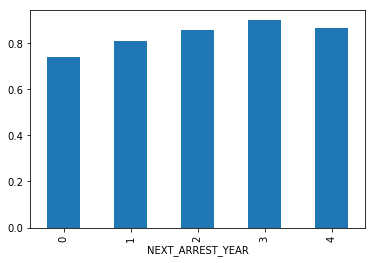

In [47]:
#Recall by next_arrest_year
pd.pivot_table(data[data['True_Y'] ==1], values = 'Pred_Y', index='NEXT_ARREST_YEAR').plot(kind="bar")

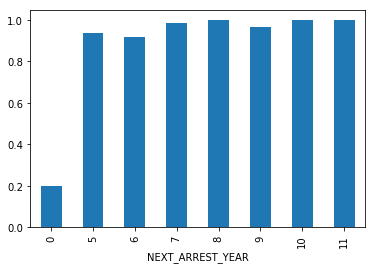

In [48]:
#Percent Predicted Positive Class with a True_Y = 0 by next_arrest_year
pd.pivot_table(data[data['True_Y'] ==0], values = 'Pred_Y', index='NEXT_ARREST_YEAR').plot(kind="bar")

#The model frequently misclassifies people who will be rearrested far in the future as rearrested within 5 years
#however, it rarely (20% of the time) misclassifies people who will never be rearrested

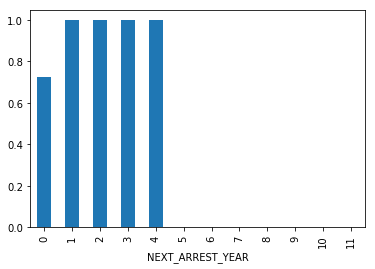

In [49]:
#Precision by next_arrest_year
pd.pivot_table(data[data['Pred_Y'] ==1], values = 'True_Y', index='NEXT_ARREST_YEAR').plot(kind="bar")

In [50]:
#Precision by next arrest year
data['COUNT'] = 1
precision_by_arrest_year = pd.pivot_table(data[data['Pred_Y'] ==1], values = ['COUNT', 'CORRECT'], index='NEXT_ARREST_YEAR', aggfunc=sum)

In [51]:
precision_by_arrest_year['Percent'] = precision_by_arrest_year['CORRECT']/precision_by_arrest_year['COUNT']

In [52]:
precision_by_arrest_year

#what does this mean? there are 3,514 records predicted as rearrested with a next_arrest_year of 0
#next_arrest_year of 0 means either not rearrested or rearrested within less than a year

,CORRECT,COUNT,Percent
NEXT_ARREST_YEAR,,,
0,2548,3509,0.726133
1,911,911,1.000000
2,472,472,1.000000
3,297,297,1.000000
4,205,205,1.000000
5,0,166,0.000000
6,0,121,0.000000
7,0,68,0.000000
8,0,38,0.000000


#### The two important boxplots

In [53]:
has_rearrest_incorrect_pred = val_error.wrong_pred[val_error.wrong_pred['True_Y'] == 1]

has_rearrest_correct_pred = val_error.right_pred[val_error.right_pred['True_Y'] == 1]

has_rearrest_incorrect_pred['NEXT_ARREST_TIME'] = has_rearrest_incorrect_pred['NEXT_ARREST_TIME']/365

has_rearrest_incorrect_pred=has_rearrest_incorrect_pred.rename(columns = {'NEXT_ARREST_TIME':'Next Arrest Time'})

has_rearrest_correct_pred['NEXT_ARREST_TIME'] = has_rearrest_correct_pred['NEXT_ARREST_TIME']/365

has_rearrest_correct_pred=has_rearrest_correct_pred.rename(columns = {'NEXT_ARREST_TIME':'Next Arrest Time'})

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


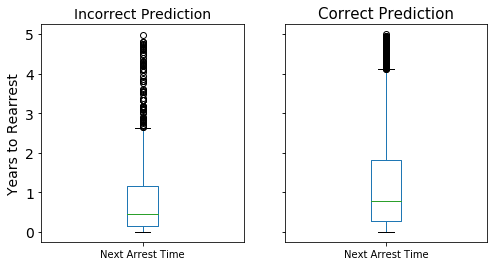

In [54]:
plt.figure(1)
plt.gcf().set_size_inches(8,4) 

rows = 1

ax1 = plt.subplot(rows,2,1)
ax1.set_title('Incorrect Prediction', fontsize=14)
ax1.set_ylabel('Years to Rearrest', fontsize = 14)
ax1.set_yticklabels(labels = [-1,0,1,2,3,4,5], fontdict = {'fontsize': 14})
has_rearrest_incorrect_pred['Next Arrest Time'].plot.box()

ax2 = plt.subplot(rows,2,2, sharey=ax1)
ax2.set_title('Correct Prediction', fontsize=15)
has_rearrest_correct_pred['Next Arrest Time'].plot.box()
plt.savefig('next_arrest_time' + '_boxplots.png')

In [59]:
data[numeric].corrwith(data['NEXT_ARREST_TIME'])

NEXT_ARREST_TIME          1.000000
ARREST_DATE_y            -0.090516
BAR_ADMIT_DAYS            0.025517
CRIMINAL_FLAG             0.360213
FINAL_DETENTION_FLAG     -0.013526
HABITUAL_OFFENDER_FLAG    0.012818
INITIAL_DETENTION_FLAG   -0.028522
JUVENILE_FLAG            -0.162318
TOT_NUM_DEF              -0.004126
MULTIPLE_DEF_FLAG        -0.003513
SCREENING_DAYS           -0.027164
ARREST_DATE_y            -0.090516
AGE                       0.071231
AGE_JUV_INVALID          -0.048660
AGE_NA                   -0.095178
ARREST_TO_SCREEN          0.043933
dtype: float64

In [60]:
correlations = data[data['True_Y'] ==1][numeric].corrwith(data[data['True_Y'] ==1]['NEXT_ARREST_TIME'])

correlations.sort_values()

JUVENILE_FLAG            -0.184845
INITIAL_DETENTION_FLAG   -0.037101
AGE_JUV_INVALID          -0.025098
SCREENING_DAYS           -0.021351
MULTIPLE_DEF_FLAG        -0.019601
TOT_NUM_DEF              -0.016906
FINAL_DETENTION_FLAG     -0.015600
AGE_NA                   -0.006150
HABITUAL_OFFENDER_FLAG    0.006206
ARREST_DATE_y             0.016555
ARREST_DATE_y             0.016555
BAR_ADMIT_DAYS            0.025845
ARREST_TO_SCREEN          0.034602
AGE                       0.145203
CRIMINAL_FLAG             0.229738
NEXT_ARREST_TIME          1.000000
dtype: float64

In [ ]:
#pretty highly correlated with criminal flag
#also negatively correlated with juvenile flag
#also slightly correlated with age

In [61]:
#Correlation between criminal flag and time to rearrest

x = np.array(data[data['True_Y'] ==1]['CRIMINAL_FLAG'])
y = np.array(data[data['True_Y'] ==1]['NEXT_ARREST_TIME'])

pearsonr(x,y)

In [65]:
data['Probability'] = best_model_predicted_prob[:,1]

In [66]:
#Correlation between next arrest time and probability of rearrest

x = np.array(data[data['True_Y'] ==1]['Probability'])
y = np.array(data[data['True_Y'] ==1]['NEXT_ARREST_TIME'])

pearsonr(x,y)

In [70]:
list_to_plot = ['AGE', 'BAR_ADMIT DAYS', 'ARREST_TO_SCREEN', 'SCREENING_DAYS', 'CRIMINAL_FLAG']

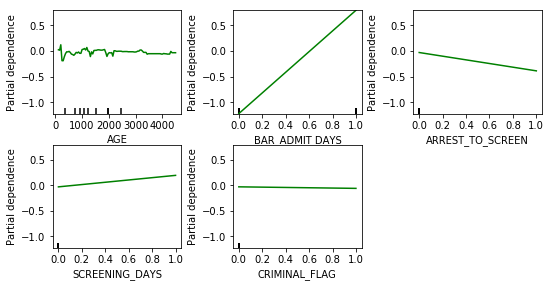

In [71]:
fig, axs = plot_partial_dependence(best_model, X_train, list_to_plot, list_to_plot)

plt.gcf().set_size_inches(8,6)

plt.savefig('partial_dependence.png')

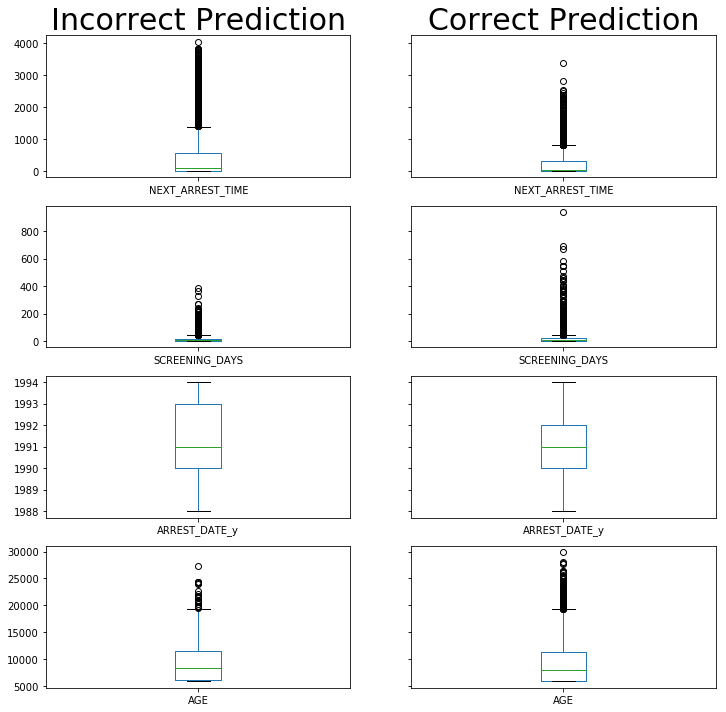

In [74]:
val_error.plot_boxplots(numeric_exc_binary)

In [75]:
val_error.mean_comparison(numeric)

val_error.correlation(numeric)

In [ ]:
#Can't recreate categorical breakdowns until the new preprocessing is on Git

In [ ]:
val_error.plot_cat_breakdowns()
plt.gcf().set_size_inches(12,36)
plt.gcf().savefig('final_categorical_breakdowns.png')